In [1]:
# check HW:
!lscpu 
# htop (activity monitor --> watch all process running on the CPUs)

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              8
On-line CPU(s) list: 0-7
Thread(s) per core:  2
Core(s) per socket:  4
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               60
Model name:          Intel(R) Core(TM) i7-4710HQ CPU @ 2.50GHz
Stepping:            3
CPU MHz:             3260.631
CPU max MHz:         3500.0000
CPU min MHz:         800.0000
BogoMIPS:            4988.81
Virtualization:      VT-x
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            6144K
NUMA node0 CPU(s):   0-7
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq dtes64 monitor ds_cpl vmx est tm2 ssse3 sdbg fma

In [2]:
from multiprocessing import Pool, cpu_count, Process
import numpy as np
import time
from itertools import repeat
from pprint import pprint
import matplotlib.pyplot as plt
import glob
import os
from PIL import Image, ImageFilter

In [3]:
print("Number of processers: ", cpu_count())

Number of processers:  8


### Example 1: computing the square value of a each element in a list.

In [3]:
def f(x):
    return x*x

In [84]:
# arr = [1, 2, 3]
N = 10000000
arr = np.random.randint(10, size=(N))
# print("Array values:", arr)

In [85]:
# Serial process:
result_serial = []#np.zeros((N))
t1 = time.time()
for i in range(len(arr)):
    # result_serial[i] = f(arr[i])
    result_serial.append(f(arr[i]))
ts = time.time() - t1
print("Serial execution time: ", ts)

Serial execution time:  4.723489761352539


In [88]:
t2 = time.time()
p = Pool(cpu_count())
result_parallel = p.map(f,arr)  # start the parallel processing, select processors automatically
p.close()                       # close the parallel pool
p.join()                        # wait for all processes to finish
tp = time.time() - t2
print("Parallel execution time: ", tp)

Parallel execution time:  45.58695101737976


In [89]:
print("Speed-up: ", ts/tp)
# We notice that the speed-up is less than 1 due to the parallel overhead times
# (initializing the processes)
# writing bottleneck ... processes would like to access the same RAM ... 
# cache writing conflicts.

Speed-up:  0.10361495243565941


### Example 2: sum of exponencials.
$$c_i = \sum_{j=0}^{9999}a_i^{b_i}$$

In [2]:
VECTOR_SIZE = 15000

array_A = []
array_B = []
array_C = []

array_A = np.random.randint(5, size=(VECTOR_SIZE))
array_B = np.random.randint(5, size=(VECTOR_SIZE))

In [3]:
def sum_of_exps(a,b):
    total = 0
    for _ in range(10000):
        total += a**b
    
    return total

In [4]:
# Serial process:
t1 = time.time()
for i in range(0, VECTOR_SIZE):
    array_C.append(sum_of_exps(array_A[i], array_B[i]))
ts = time.time() - t1
print("Serial execution time: ", ts)

Serial execution time:  24.14407968521118


In [5]:
# Parallel process:
joined_vector = zip(array_A, array_B)
t2 = time.time()
p = Pool(cpu_count())
array_C = p.starmap(sum_of_exps, joined_vector)
p.close()
p.join()
tp = time.time() - t2
print("Parallel execution time: ", tp)

Parallel execution time:  13.141814947128296


In [6]:
print("Speed-up: ", ts/tp)

Speed-up:  1.8371952262565576


### Example 3: Matrix-vector multiplication (applications: image processing, signal filtering, ...)

We have the following matrix:
$$ A = \begin{bmatrix} a_{11} & a_{12} & a_{13} & \cdots & a_{1n} \\
a_{21} & a_{22} & a_{23} & \cdots & a_{2n}\\
& & \vdots & &\\
a_{m1} & a_{m2} & a_{m3} & \cdots & a_{mn} \end{bmatrix}$$

and the following vector:
$$v = \begin{bmatrix} b_1 \\ b_2 \\ b_3 \\ \vdots \\ b_n \end{bmatrix}$$

In [7]:
M = 10000
N = 10000

result_serial = []
matrix_A = np.random.randint(100, size=(M,N))
vector_v = np.random.randint(100, size=(N))

In [8]:
def dot_product(x,y):
    sum = 0
    for i in range(N):
        sum += x[i]*y[i]
    
    return sum

In [9]:
# Serial process:
t1 = time.time()
for row in matrix_A:
    result_serial.append(dot_product(row, vector_v))
ts = time.time() - t1
print("Serial execution time: ", ts)

Serial execution time:  54.8948655128479


In [10]:
# Parallel process:
joined_vector = zip(matrix_A, repeat(vector_v))
t2 = time.time()
p = Pool(cpu_count())
result_parallel = p.starmap(dot_product, joined_vector)
p.close()
p.join()
tp = time.time() - t2
print("Parallel execution time: ", tp)

Parallel execution time:  19.529544591903687


In [105]:
assert result_serial == result_parallel
print("Speed-up: ", ts/tp)

Speed-up:  2.857060024501563


In [11]:
from joblib import Parallel, delayed 

t3 = time.time()
processed_list = Parallel(n_jobs=8)(delayed(dot_product)(row, vector_v) for row in matrix_A)
tjoblib = time.time() - t3
print("Parallel execution time using joblib: ", tjoblib)

Parallel execution time using joblib:  19.533869743347168


In [112]:
t3 = time.time()
Av = np.dot(matrix_A, vector_v)
tnumpy = time.time() - t3
print("Numpy execution time: ", tnumpy)
assert result_serial == Av.tolist()

# Comment: numpy uses AVX optimization --> single instruction, multiple data (SIMD)
# bit-level parallelism
# AVX uses CPU registers of 512 bits which can process up to 16 float numbers in parallel.

Numpy execution time:  0.1317138671875


### Example 4: image histogram.


rows: 2304, cols: 2880


(-0.5, 2879.5, 2303.5, -0.5)

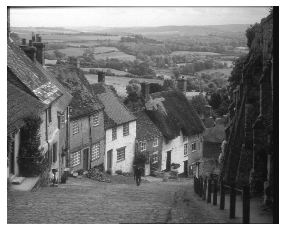

In [182]:
# Reading image:
img = np.load('goldhill.npy')
print(f'rows: {img.shape[0]}, cols: {img.shape[1]}')
plt.figure()
plt.imshow(img, cmap='gray')
plt.axis('off')

In [183]:
def my_histogram(img):
    hist = np.zeros((256))
    M = len(img)     #imagen.shape[0] -- rows
    N = len(img[0])  #imagen.shape[1] -- cols
    for i in range(M):
        for j in range(N):
            hist[img[i][j]] += 1

    return hist

Serial execution time:  6.930336236953735


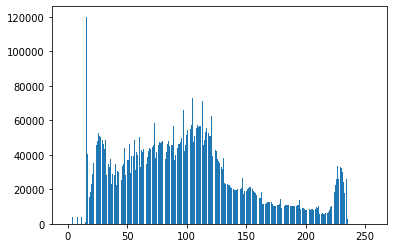

In [184]:
# Serial process:
t1 = time.time()
hist_serial = my_histogram(img)
ts = time.time() - t1
print("Serial execution time: ", ts)

plt.figure()
plt.bar(range(0, len(hist_serial)), hist_serial)
plt.savefig('hist_serial.png', bbox_inches='tight')

(1200, 2880) (1104, 2880) [0, 1200]
Parallel execution time:  4.108652353286743


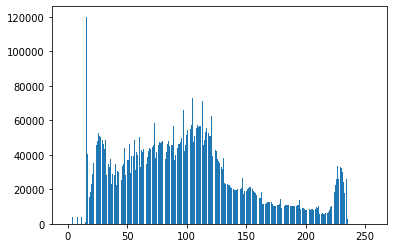

In [196]:
# Parallel process:
# Split the image into two sub_images.
chunks = [img[x:x+1200] for x in range(0, len(img), 1200)]
# print('chunks: ')
# pprint(chunks)
print(chunks[0].shape, chunks[1].shape, list(range(0, len(img), 1200)))

t2 = time.time()
p = Pool() # it uses only 2 processes automatically -- 2 chunks of data
hist_chunks = p.map(my_histogram, chunks)
merged_hist = [sum(x) for x in zip(hist_chunks[0], hist_chunks[1])]
tp_2 = time.time() - t2
print("Parallel execution time: ", tp_2)

plt.figure()
plt.bar(range(0, len(merged_hist)), merged_hist)
plt.savefig('hist_parallel.png', bbox_inches='tight')

In [197]:
print("Speed-up (using two imgs): ", ts/tp_2)

Speed-up (using two imgs):  1.6867662778550168


(576, 2880) (576, 2880) (576, 2880) (576, 2880) [0, 600, 1200, 1800]
Parallel execution time:  2.6605794429779053


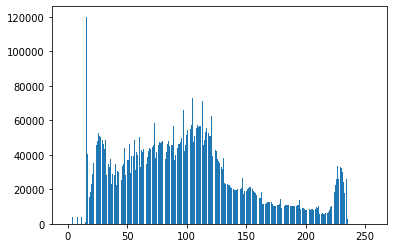

In [200]:
# Parallel process:
# Split the image into four sub_images.
Nrows = len(img)//4
chunks = [img[x:x+Nrows] for x in range(0, len(img), Nrows)]
# print('chunks: ')
# pprint(chunks)
print(chunks[0].shape, chunks[1].shape, chunks[2].shape, chunks[3].shape, list(range(0, len(img), 600)))

t3 = time.time()
p = Pool() # it uses only 4 processes automatically -- 4 chunks of data
hist_chunks = p.map(my_histogram, chunks)
merged_hist = [sum(x) for x in zip(hist_chunks[0], hist_chunks[1], hist_chunks[2], hist_chunks[3])]
tp_4 = time.time() - t3
print("Parallel execution time: ", tp_4)

plt.figure()
plt.bar(range(0, len(merged_hist)), merged_hist)
plt.savefig('hist_parallel_4subimg.png', bbox_inches='tight')

In [201]:
print("Speed-up (using 4 imgs): ", ts/tp_4)

Speed-up (using 4 imgs):  2.6048221394948543


### Example 5: processing multiple images.


In [246]:
def img_filter(img_names, idx, results_path):
    for i in idx:
        img = Image.open(img_names[i]).convert('L') # load image in grayscale
        img = img.resize((img.size[0]*8,img.size[1]*8)) # resize four times bigger

        # img_neg = img.point(lambda i: 255 - i)  # compute the negative of each pixel (lambda is an intrisic function)
        img_fil = img.filter(ImageFilter.FIND_EDGES) # fine edges in the image
        
        img_fil.save(os.path.join(results_path,img_names[i].split('/')[-1]))

In [228]:
# Define the path for the images
img_path = './data'
img_names = sorted(glob.glob(os.path.join(img_path,'*.png')))
results_path = './results'

os.makedirs(results_path, exist_ok=True)

idx = list(range(len(img_names))) # we want to process all img in data folder
pprint(img_names)

['./data/barbara_gray512.png',
 './data/boats_gray.png',
 './data/goldhill_gray.png',
 './data/horse.png',
 './data/lena_gray_512.png',
 './data/lighthouse_gray.png',
 './data/mandrill_gray.png',
 './data/peppers_gray.png']


In [238]:
# Serial processing:
t1 = time.time()
img_filter(img_names, idx, results_path)
ts = time.time() - t1
print("Serial execution time: ", ts)

Serial execution time:  4.378103733062744


In [247]:
# Parallel processing:
NUM_PROC = 4 # number of processors in PC to be used
# NUM_PROC = cpu_count() # number of processors in PC to be used
imgs_per_proc = (len(idx)//NUM_PROC)

t2 = time.time()
jobs = []
for i in range(NUM_PROC):
    print(f'Processor {i}: img_names{idx[i*imgs_per_proc:(i+1)*imgs_per_proc]}')
    # each process will execute the target function in the same number of images.
    process = Process(target=img_filter, args=(img_names, idx[i*imgs_per_proc:(i+1)*imgs_per_proc], results_path))
    jobs.append(process)

for j in jobs:
    j.start()

for j in jobs:
    j.join()  

tp = time.time() - t2  
print("Parallel execution time: ", tp)

Processor 0: img_names[0, 1]
Processor 1: img_names[2, 3]
Processor 2: img_names[4, 5]
Processor 3: img_names[6, 7]
Parallel execution time:  3.303287982940674


In [242]:
print("Speed-up: ", ts/tp)

Speed-up:  2.418632286085938
